In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd

In [3]:

def jumbo_scrapper(busqueda):

    cService = webdriver.ChromeService()
    driver = webdriver.Chrome(service=cService)
    # Define the URL

    url = f"https://www.jumbo.cl/busqueda?ft={busqueda}&page=1&hitsPerPage=27"

    # load the web page
    driver.get(url)

    driver.implicitly_wait(30)
    contents = driver.find_elements(By.CLASS_NAME, "product-card-name")
    prices = driver.find_elements(By.CLASS_NAME, "prices-main-price")
    brands = driver.find_elements(By.CLASS_NAME, "product-card-brand")
    

    products = [ content.text for content in contents]
    #create a prices list but if the price is not available, it will be replaced by 0
    prices_list = [ str(price.text) if price.text else str(0) for price in prices]
    prices_list = [' $' + str(float(price.split('x')[1].replace(' $','').replace('.',''))/float(price.split('x')[0].replace(' $',''))) if 'x' in price else price for price in prices_list]
    links = [elem.get_attribute('href') for elem in contents]

    df = pd.DataFrame(list(zip(products, prices_list, links)), columns =[ 'Product', 'Price', 'Link'])

    return df


def lider_scrapper(busqueda):
    cService = webdriver.ChromeService()
    driver = webdriver.Chrome(service=cService)
    url = f"https://www.lider.cl/supermercado/search?query={busqueda}&page=1&hitsPerPage=27"
    driver.get(url)

    driver.implicitly_wait(10)
    contents = driver.find_elements(By.CLASS_NAME, "product-card_description-wrapper")
    prices = driver.find_elements(By.CLASS_NAME, "product-card__sale-price")
    #get the links of the products, there are on a a tag with data-testid = product-card-nav-test-id
    links_wb = driver.find_elements(By.XPATH, "//a[@data-testid='product-card-nav-test-id']")

    products = [ content.text for content in contents]
    #create a prices list but if the price is not available, it will be replaced by 0
    prices_list = [ str(price.text) if price.text else str(0) for price in prices]
    prices_list = [' $' + str(float(price.split('x')[1].replace(' $','').replace('.',''))/float(price.split('x')[0].replace(' $',''))) if 'x' in price else price for price in prices_list]
    links = [links_wb.get_attribute('href') for links_wb in links_wb]
    df = pd.DataFrame(list(zip(products, prices_list, links)), columns =[ 'Product', 'Price', 'Link'])
    return df

def S_isabel_scrapper(busqueda):
    cService = webdriver.ChromeService()
    driver = webdriver.Chrome(service=cService)
    url = f"https://www.santaisabel.cl/busqueda?ft={busqueda}&page=1&hitsPerPage=27"
    driver.get(url)

    driver.implicitly_wait(30)
    contents = driver.find_elements(By.CLASS_NAME, "product-card-name")
    prices = driver.find_elements(By.CLASS_NAME, "prices-main-price")
    links = [elem.get_attribute('href') for elem in contents]
    products = [ content.text for content in contents]
    #create a prices list but if the price is not available, it will be replaced by 0
    prices_list = [ str(price.text) if price.text else str(0) for price in prices]
    prices_list = [' $' + str(float(price.split('x')[1].replace(' $','').replace('.',''))/float(price.split('x')[0].replace(' $',''))) if 'x' in price else price for price in prices_list]

    df = pd.DataFrame(list(zip(products, prices_list, links)), columns =[ 'Product', 'Price', 'Link'])

    return df





In [4]:
def product_per_money(products, prices,links):
    sorter = []
    weights = []
    for title, price in zip(products, prices):
        #weight is equal to the numbers directly before the word "gr" or "kg" on the title
        title_list = title.split()
        if 'g' in title_list:
            weight = title_list[title_list.index('g')-1]
            weights.append(weight)
        elif 'kg' in title_list:
            if title_list[title_list.index('kg')-1].isdigit():
                weight = title_list[title_list.index('kg')-1]+'000'
                weights.append(weight)
            else:
                weight = '1000'
                weights.append(weight)

    #create a list with the price per weight
    for price, weight in zip(prices, weights):
        price_per_weight = float(price.replace('$','').replace('.',''))/float(weight)
        sorter.append(round(price_per_weight,2))

    df = pd.DataFrame(list(zip(products, prices, weights, sorter,links)), columns =['Product', 'Price', 'Weight', 'weight/price', 'Link'])
    return df 
    
def price_detector(busqueda):
    df_jumbo = jumbo_scrapper(busqueda)
    df_lider = lider_scrapper(busqueda)
    df_santaisabel = S_isabel_scrapper(busqueda)

    df_jumbo = product_per_money(df_jumbo['Product'], df_jumbo['Price'], df_jumbo['Link'])
    df_lider = product_per_money(df_lider['Product'], df_lider['Price'], df_lider['Link'])
    df_santaisabel = product_per_money(df_santaisabel['Product'], df_santaisabel['Price'], df_santaisabel['Link'])

    df_jumbo.loc[:,'supermarket'] = 'Jumbo'
    df_lider.loc[:,'supermarket'] = 'Lider'
    df_santaisabel.loc[:,'supermarket'] = 'Santa Isabel'


    full_list = pd.concat([df_jumbo, df_lider, df_santaisabel], axis=0)
    full_list = full_list.sort_values(by='weight/price', ascending=True)
    return full_list




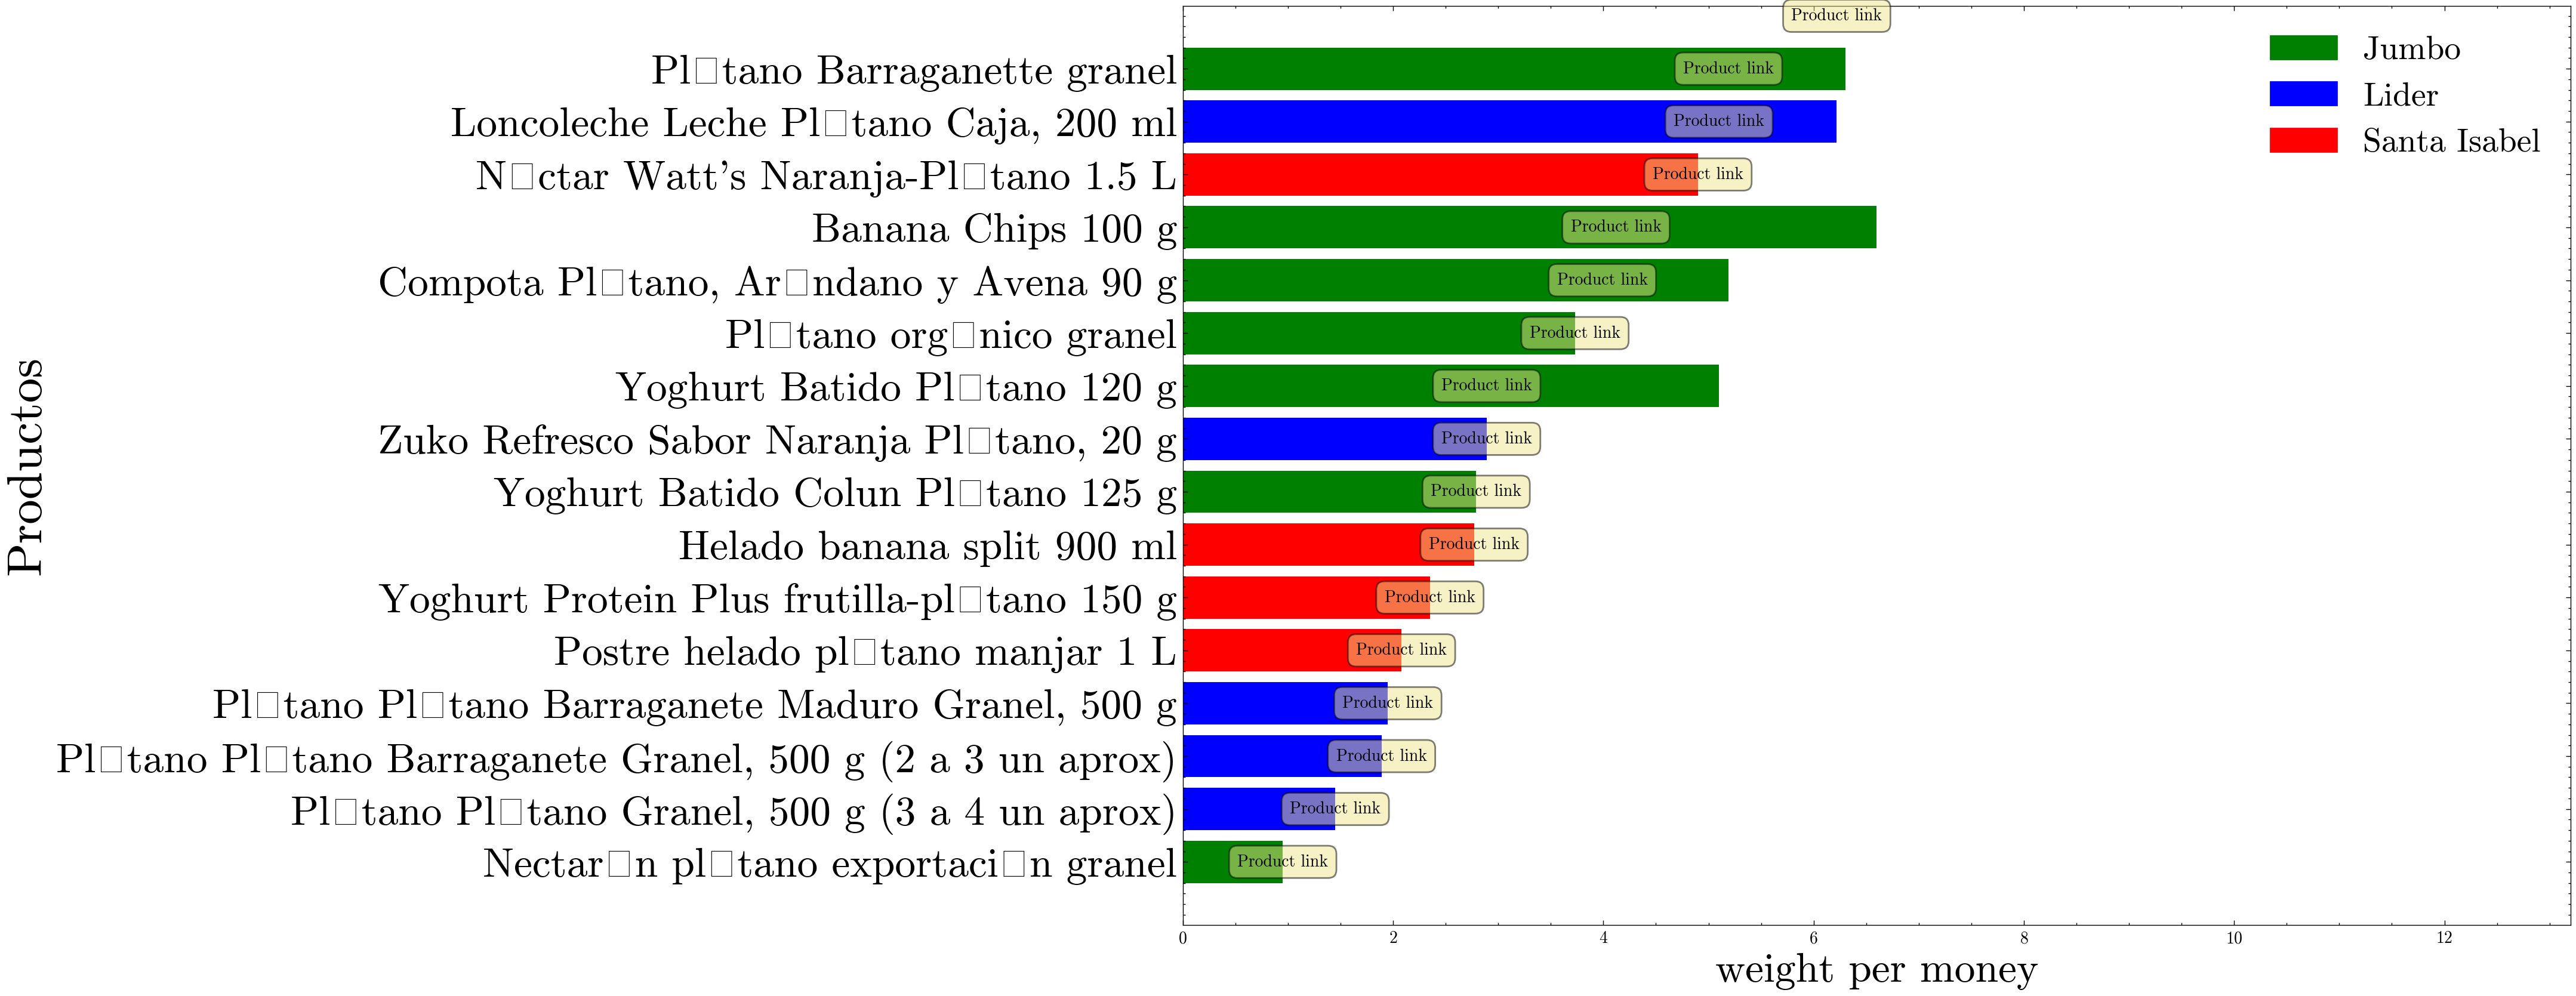

In [53]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import warnings
import numpy as np
import re
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)
plt.style.use(['science','no-latex'])
busqueda = 'platano'
full_product_list = price_detector(busqueda)
full_product_list


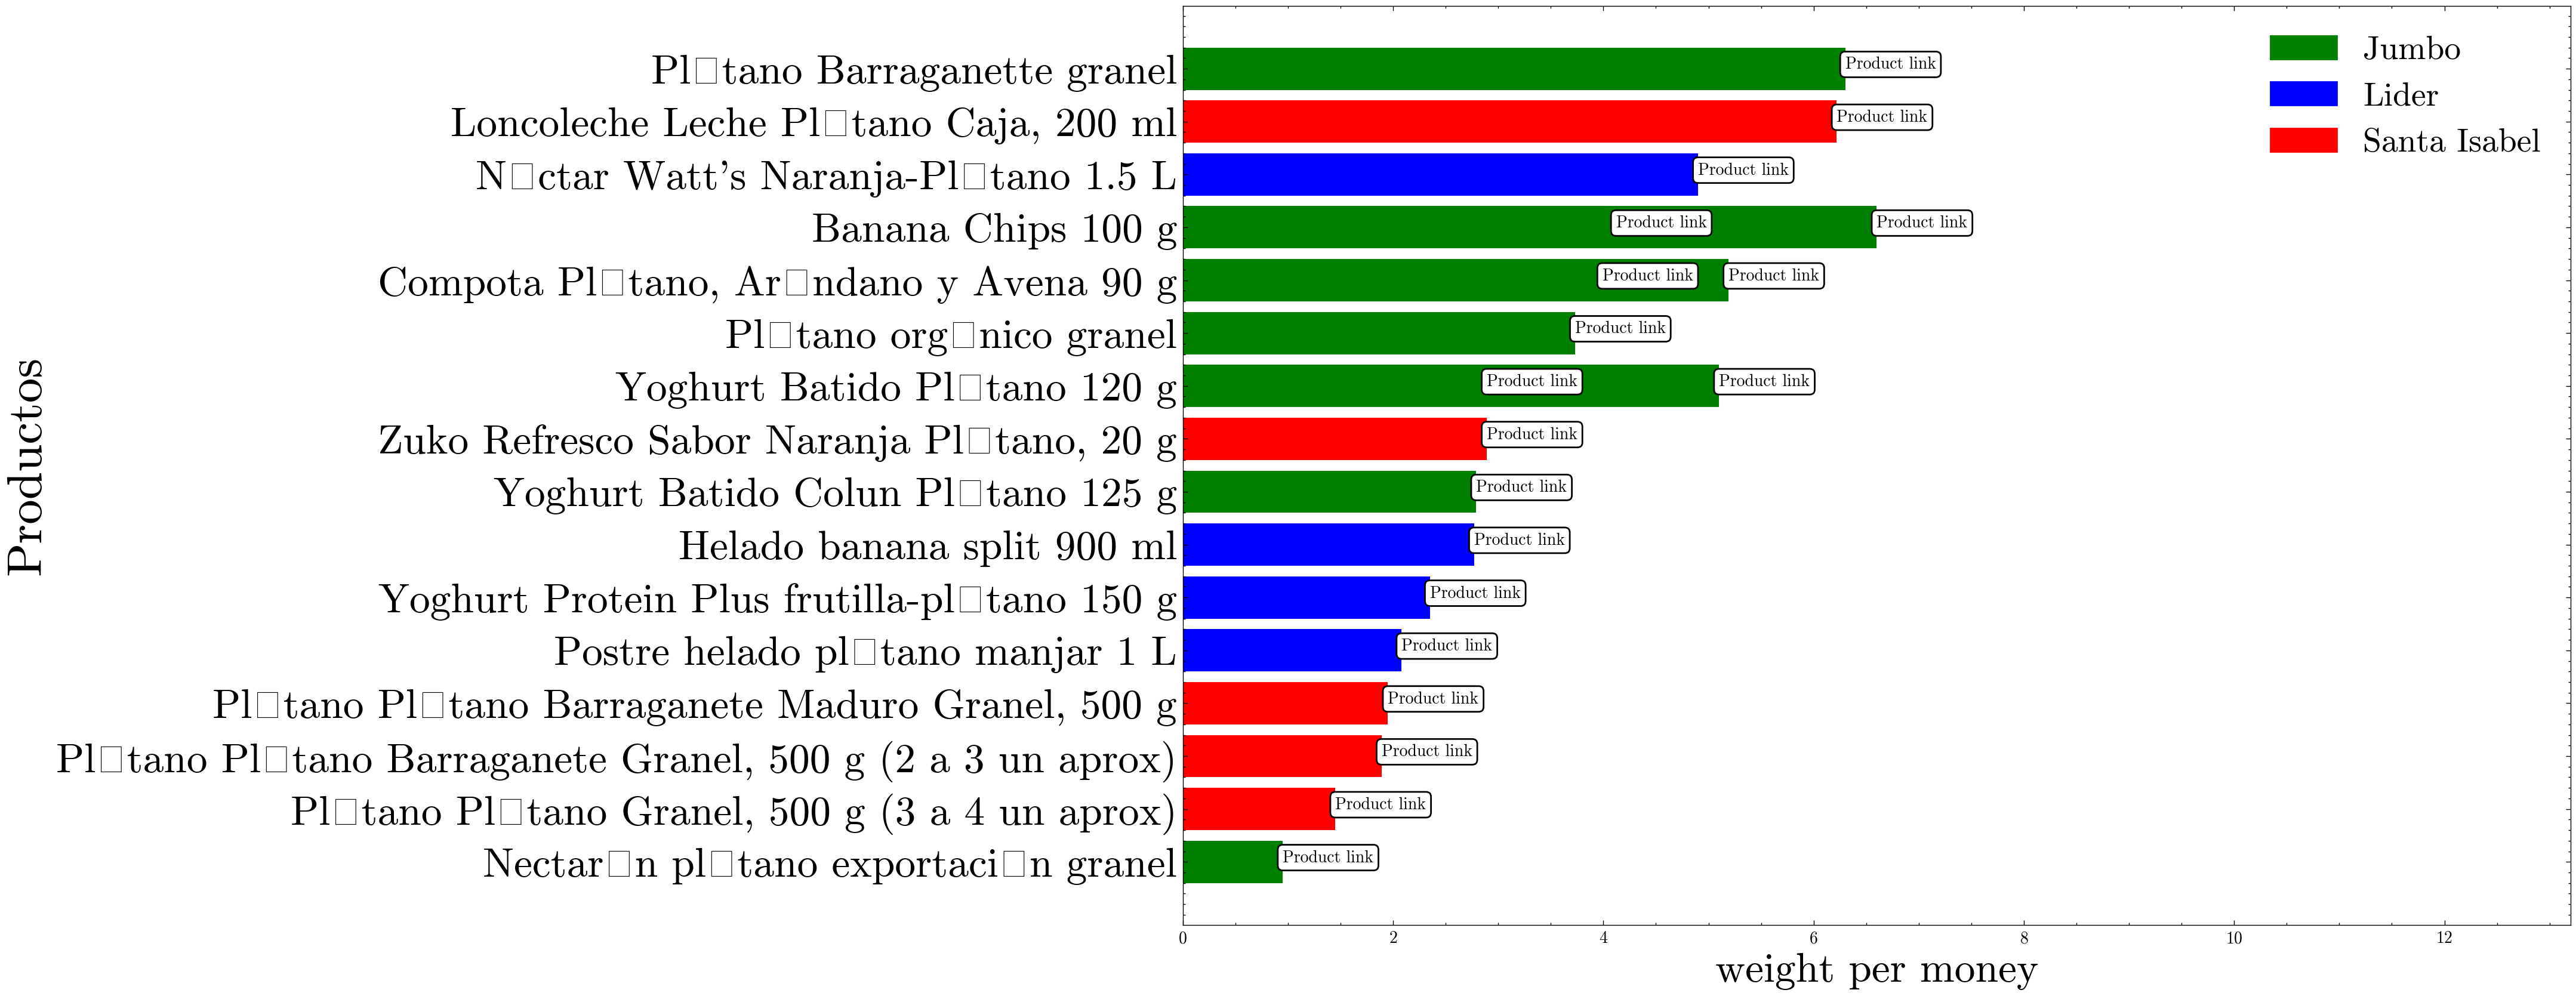

In [118]:

def ploting(df):
    products = df['Product']
    weight_per_money = df['weight/price']
    supermarket = df['supermarket']
    links = df['Link']

    plt.figure(figsize=(15, 10), dpi=200)
    #increase figure margins
    plt.margins(x=1)
    #if the supermarket is jumbo, the bar will be blue, if it is lider, the bar will be red
    for i in range(19):
        

        if supermarket.iloc[i] == 'Jumbo':
            
            bars = plt.barh(products.iloc[i], weight_per_money.iloc[i], color = 'green')
            #add the link to the product in anotation with rounded corners
            plt.annotate('Product link', xy=(weight_per_money.iloc[i], products.iloc[i]), xytext=(weight_per_money.iloc[i], products.iloc[i]), bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1),
                        url=links.iloc[i])
        elif supermarket.iloc[i] == 'Lider':
            bars = plt.barh(products.iloc[i], weight_per_money.iloc[i], color = 'red')
            plt.annotate('Product link', xy=(weight_per_money.iloc[i], products.iloc[i]), xytext=(weight_per_money.iloc[i], products.iloc[i]), bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1),
                        url=links.iloc[i])
        elif supermarket.iloc[i] == 'Santa Isabel':
            bars = plt.barh(products.iloc[i], weight_per_money.iloc[i], color = 'blue')
            plt.annotate('Product link', xy=(weight_per_money.iloc[i], products.iloc[i]), xytext=(weight_per_money.iloc[i], products.iloc[i]), bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1),
                        url=links.iloc[i])
    leg = plt.legend(['Jumbo', 'Lider', 'Santa Isabel'], fontsize=20)
    leg.legendHandles[0].set_color('Green')
    leg.legendHandles[1].set_color('Blue')
    leg.legendHandles[2].set_color('Red')
    plt.yticks(fontsize=20)
    plt.xlabel('weight per money', fontsize=25)
    plt.ylabel('Productos', fontsize=30)
    plt.yticks(fontsize=25)
    plt.savefig('products.pdf')

ploting(full_product_list)
plt.show()




